In [19]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from helpers.utils import ENVIRONMENTS_MAP, ALGORITHMS_NAME_MAP, ENVIRONMENT_TO_ALGORITHMS_MAP, ALGORITHMS_COLOR_MAP

SEEDS = [5, 26, 47, 76, 92]
ENV_NAME = 'MOSuperMarioBrosZeroShot-v2'
METRIC = 'eval/single_objective_return'
SMOOTHING = 0.9

# comment out if not necessary for your use case
EVAL_ALGORITHMS = ENVIRONMENT_TO_ALGORITHMS_MAP[ENV_NAME].copy()

# EVAL_ALGORITHMS.remove('PGMORL')
# EVAL_ALGORITHMS.remove('PCN continuous action')

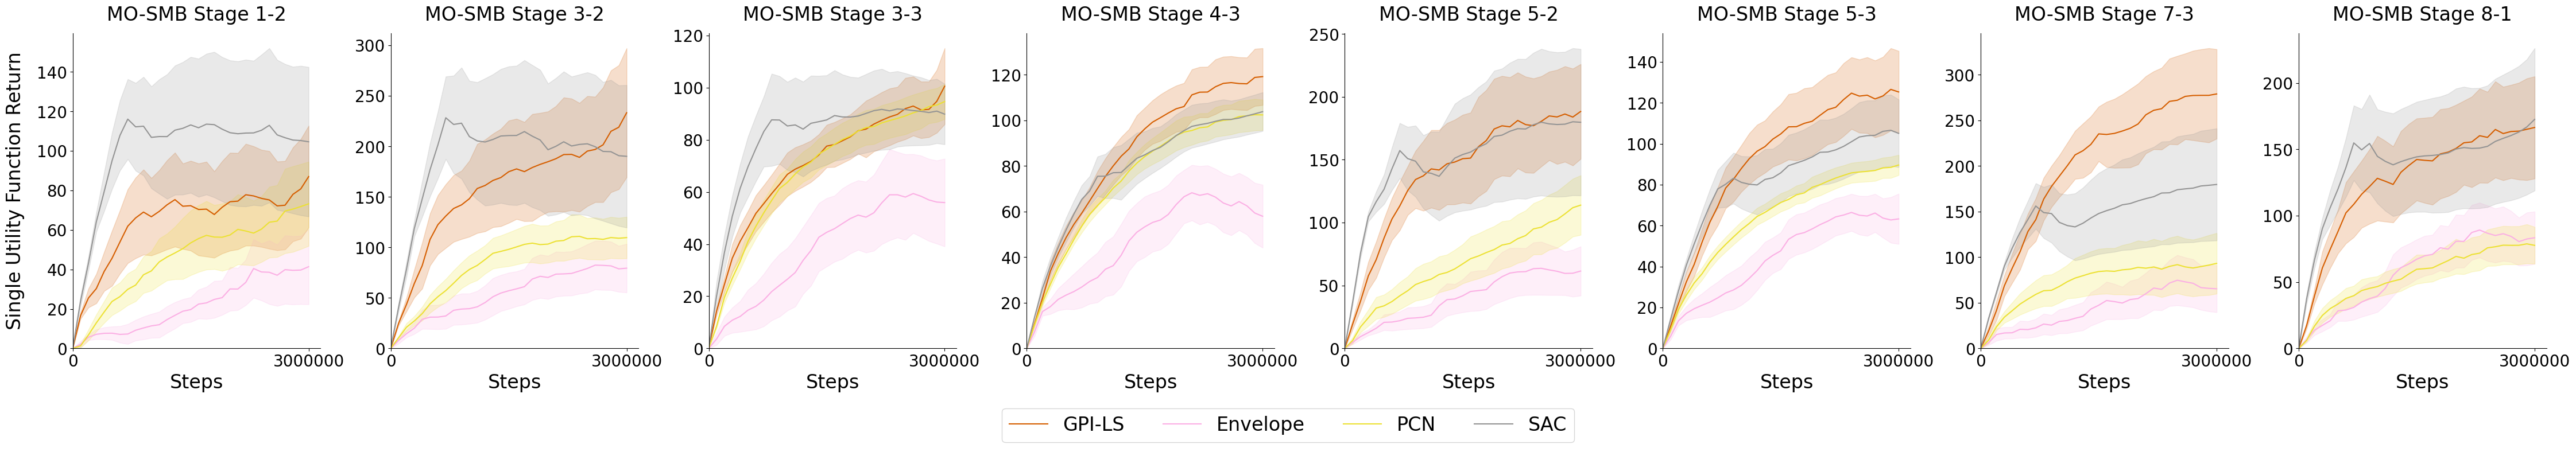

In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# EMA Smoothing
def exponential_smoothing(data, alpha=0.99):
    smoothed_data = np.zeros_like(data)
    smoothed_data[0] = data[0]  # Initialize the first value
    for t in range(1, len(data)):
        smoothed_data[t] = alpha * smoothed_data[t-1] + (1 - alpha) * data[t]
    return smoothed_data

base_dir = f"data/{METRIC}"

# Colors for each algorithm
colors = sns.color_palette('colorblind')

environments = ENVIRONMENTS_MAP[ENV_NAME]
def rename_environment(env_name):
    # Remove the version part
    base_name = env_name.split('-')[0]
    # Insert a hyphen after "MO"
    renamed = base_name[:2] + '-' + base_name[2:]
    return renamed

renamed_environments = [rename_environment(env) for env in environments]
fig, axs = plt.subplots(1, len(environments), figsize=(30, 7))  # Remove sharey=True to allow independent Y-axis scaling

for env_idx, env in enumerate(renamed_environments):
    ax = axs[env_idx]  # Get the corresponding subplot axis for the environment
    ax.set_title(env, fontsize=24, pad=16)  # Set the title of the subplot
    
    for alg_idx, algorithm in enumerate(EVAL_ALGORITHMS):
        all_seeds_data = []
        
        for seed in SEEDS:
            # Construct the file path
            file_path = os.path.join(base_dir, environments[env_idx], algorithm, f'seed_{seed}.csv')
            
            # Load the data
            if os.path.exists(file_path):
                data = pd.read_csv(file_path)
                # This is a hack to make the plot look better, but it's not necessary if you logged at global_step=0
                fake_row = pd.DataFrame({'global_step': [0.0], METRIC: [0.0]})
                data = pd.concat([fake_row, data], ignore_index=True)
                all_seeds_data.append(data[METRIC])
        
        if all_seeds_data:
            # Convert to a DataFrame and calculate mean and std
            combined_data = pd.DataFrame(all_seeds_data).T  # Transpose to have one row per timestep
            mean_data = combined_data.mean(axis=1)
            sem_data = combined_data.sem(axis=1)
            
            # Apply exponential smoothing
            smoothed_mean = exponential_smoothing(mean_data.values, alpha=SMOOTHING)
            smoothed_sem = exponential_smoothing(sem_data.values, alpha=SMOOTHING)
            
            # Plot with error bars in the current subplot
            algo_name = ALGORITHMS_NAME_MAP[algorithm]
            ax.plot(data['global_step'], smoothed_mean, label=algo_name, color=ALGORITHMS_COLOR_MAP[algo_name])
            ax.fill_between(data['global_step'],  
                            smoothed_mean - smoothed_sem, 
                            smoothed_mean + smoothed_sem, 
                            color=ALGORITHMS_COLOR_MAP[algo_name], alpha=0.2)
    
    ax.set_xlabel("Steps", fontsize=24)
    ax.set_xticks([0, data['global_step'].max()])  # Show only 0 and the last global step
    ax.set_xticklabels([0, f"{int(data['global_step'].max())}"])  # Only show 0 and last global_step
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    if env_idx == 0:
        ax.set_ylabel("Single Utility Function Return", labelpad=15, fontsize=24)
    
    # Set axes limits to ensure all graphs start at the bottom left
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=0)
    # Remove grid and top-right borders
    ax.grid(False)  # Disable grid
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add a legend at the bottom across all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', fontsize=24, ncol=len(EVAL_ALGORITHMS))  # Increase fontsize

plt.tight_layout(rect=[0, 0.12, 1, 1])  # Leave space for the legend at the bottom

# Change save format to PNG if you prefer bitmap images
plt.savefig(f'images/{ENV_NAME}_single_objective_return.svg', format='svg', bbox_inches='tight')
plt.show()